In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
# Delete original test set, split the train set into train and validation, and assign original validation set to test set

dataset["test"] = dataset["validation"]

train_size = int(len(dataset["train"]) * 0.98)
train_set = dataset["train"].select(list(range(train_size)))
validation_set = dataset["train"].select(list(range(train_size, len(dataset["train"]))))
dataset["train"] = train_set
dataset["validation"] = validation_set

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 66002
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1347
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})


In [5]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# BitFit: freeze everything except for bias terms 

for name, param in model.named_parameters():
    if "bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

total_params = sum(param.numel() for param in model.parameters())
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Percentage trainable: {trainable_params / total_params * 100:.2f}%")

Total params: 124647170
Trainable params: 102914
Percentage trainable: 0.08%


In [7]:
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

In [8]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import logging

# Hyperparameters
step_size = 500
lr = 1e-4
num_epochs = 1


# Eval metric for accuracy
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


# Custom trainer for logging training accuracy
class TrainerWithTrainingAccuracy(Trainer):
    training_accuracies = []
    # curr_step = 0

    def training_step(self, model, inputs):
        # Perform a regular training step
        loss = super().training_step(model, inputs)
        
        # Compute training accuracy after every training step
        self.log_training_accuracy(inputs)
        return loss

    def log_training_accuracy(self, inputs):
        model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            labels = inputs["labels"]
            predictions = np.argmax(logits.cpu().numpy(), axis=-1)
            labels = labels.cpu().numpy()
            accuracy = metric.compute(predictions=predictions, references=labels)
            self.training_accuracies.append(accuracy["accuracy"])
            # self.log({"train_accuracy": accuracy["accuracy"]})
        if len(self.training_accuracies) % step_size == 0:
            self.log({"train_accuracy": sum(self.training_accuracies) / len(self.training_accuracies)})
            self.training_accuracies = []
        model.train()


training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    logging_dir='./bitfit_logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./bitfit_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)

trainer = TrainerWithTrainingAccuracy(
    model=model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_11260\3571061669.py:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` 

{'train_accuracy': 0.5435, 'epoch': 0.03}
{'loss': 0.6882, 'learning_rate': 9.696988061329618e-05, 'epoch': 0.03}


                                                     
  3%|▎         | 500/16501 [02:34<1:08:53,  3.87it/s]

{'eval_loss': 0.683150053024292, 'eval_accuracy': 0.5664439495174461, 'eval_runtime': 26.2105, 'eval_samples_per_second': 51.392, 'eval_steps_per_second': 12.857, 'epoch': 0.03}


  6%|▌         | 1000/16501 [04:41<1:06:43,  3.87it/s]

{'train_accuracy': 0.555, 'epoch': 0.06}
{'loss': 0.6842, 'learning_rate': 9.393976122659234e-05, 'epoch': 0.06}


                                                      
  6%|▌         | 1000/16501 [05:07<1:06:43,  3.87it/s]

{'eval_loss': 0.6770097613334656, 'eval_accuracy': 0.5664439495174461, 'eval_runtime': 26.1155, 'eval_samples_per_second': 51.579, 'eval_steps_per_second': 12.904, 'epoch': 0.06}


  9%|▉         | 1500/16501 [07:10<1:05:15,  3.83it/s] 

{'train_accuracy': 0.7455, 'epoch': 0.09}
{'loss': 0.5574, 'learning_rate': 9.09096418398885e-05, 'epoch': 0.09}


                                                      
  9%|▉         | 1500/16501 [07:35<1:05:15,  3.83it/s]

{'eval_loss': 0.3562694489955902, 'eval_accuracy': 0.8685968819599109, 'eval_runtime': 24.9264, 'eval_samples_per_second': 54.039, 'eval_steps_per_second': 13.52, 'epoch': 0.09}


 12%|█▏        | 2000/16501 [09:39<58:19,  4.14it/s]   

{'train_accuracy': 0.8775, 'epoch': 0.12}
{'loss': 0.3803, 'learning_rate': 8.787952245318465e-05, 'epoch': 0.12}


                                                    
 12%|█▏        | 2000/16501 [10:03<58:19,  4.14it/s]

{'eval_loss': 0.38432273268699646, 'eval_accuracy': 0.8559762435040832, 'eval_runtime': 24.8343, 'eval_samples_per_second': 54.24, 'eval_steps_per_second': 13.57, 'epoch': 0.12}


 15%|█▌        | 2500/16501 [12:07<57:55,  4.03it/s]   

{'train_accuracy': 0.8885, 'epoch': 0.15}
{'loss': 0.3606, 'learning_rate': 8.484940306648083e-05, 'epoch': 0.15}


                                                    
 15%|█▌        | 2500/16501 [12:32<57:55,  4.03it/s]

{'eval_loss': 0.32624727487564087, 'eval_accuracy': 0.8812175204157386, 'eval_runtime': 24.8064, 'eval_samples_per_second': 54.3, 'eval_steps_per_second': 13.585, 'epoch': 0.15}


 18%|█▊        | 3000/16501 [14:35<55:52,  4.03it/s]   

{'train_accuracy': 0.878, 'epoch': 0.18}
{'loss': 0.3564, 'learning_rate': 8.181928367977699e-05, 'epoch': 0.18}


                                                    
 18%|█▊        | 3000/16501 [15:00<55:52,  4.03it/s]

{'eval_loss': 0.3192754089832306, 'eval_accuracy': 0.8916109873793615, 'eval_runtime': 24.9078, 'eval_samples_per_second': 54.08, 'eval_steps_per_second': 13.53, 'epoch': 0.18}


 21%|██        | 3500/16501 [17:04<53:40,  4.04it/s]   

{'train_accuracy': 0.8845, 'epoch': 0.21}
{'loss': 0.3389, 'learning_rate': 7.878916429307314e-05, 'epoch': 0.21}


                                                    
 21%|██        | 3500/16501 [17:28<53:40,  4.04it/s]

{'eval_loss': 0.40325450897216797, 'eval_accuracy': 0.8663697104677061, 'eval_runtime': 24.8904, 'eval_samples_per_second': 54.117, 'eval_steps_per_second': 13.539, 'epoch': 0.21}


 24%|██▍       | 4000/16501 [19:32<52:36,  3.96it/s]   

{'train_accuracy': 0.88, 'epoch': 0.24}
{'loss': 0.3787, 'learning_rate': 7.575904490636932e-05, 'epoch': 0.24}


                                                    
 24%|██▍       | 4000/16501 [19:57<52:36,  3.96it/s]

{'eval_loss': 0.3388642966747284, 'eval_accuracy': 0.8878990348923533, 'eval_runtime': 24.9553, 'eval_samples_per_second': 53.977, 'eval_steps_per_second': 13.504, 'epoch': 0.24}


 27%|██▋       | 4500/16501 [22:00<49:46,  4.02it/s]   

{'train_accuracy': 0.895, 'epoch': 0.27}
{'loss': 0.346, 'learning_rate': 7.272892551966548e-05, 'epoch': 0.27}


                                                    
 27%|██▋       | 4500/16501 [22:25<49:46,  4.02it/s]

{'eval_loss': 0.3278927206993103, 'eval_accuracy': 0.8849294729027468, 'eval_runtime': 25.1449, 'eval_samples_per_second': 53.57, 'eval_steps_per_second': 13.402, 'epoch': 0.27}


 30%|███       | 5000/16501 [24:28<47:13,  4.06it/s]   

{'train_accuracy': 0.891, 'epoch': 0.3}
{'loss': 0.3472, 'learning_rate': 6.969880613296165e-05, 'epoch': 0.3}


                                                    
 30%|███       | 5000/16501 [24:53<47:13,  4.06it/s]

{'eval_loss': 0.3309191167354584, 'eval_accuracy': 0.8923533778767632, 'eval_runtime': 25.0201, 'eval_samples_per_second': 53.837, 'eval_steps_per_second': 13.469, 'epoch': 0.3}


 33%|███▎      | 5500/16501 [26:55<44:39,  4.11it/s]   

{'train_accuracy': 0.89, 'epoch': 0.33}
{'loss': 0.3476, 'learning_rate': 6.666868674625781e-05, 'epoch': 0.33}


                                                    
 33%|███▎      | 5500/16501 [27:20<44:39,  4.11it/s]

{'eval_loss': 0.33134615421295166, 'eval_accuracy': 0.8916109873793615, 'eval_runtime': 25.003, 'eval_samples_per_second': 53.873, 'eval_steps_per_second': 13.478, 'epoch': 0.33}


 36%|███▋      | 6000/16501 [29:24<43:50,  3.99it/s]   

{'train_accuracy': 0.897, 'epoch': 0.36}
{'loss': 0.3253, 'learning_rate': 6.363856735955397e-05, 'epoch': 0.36}


                                                    
 36%|███▋      | 6000/16501 [29:49<43:50,  3.99it/s]

{'eval_loss': 0.33408185839653015, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 24.8489, 'eval_samples_per_second': 54.208, 'eval_steps_per_second': 13.562, 'epoch': 0.36}


 39%|███▉      | 6500/16501 [31:53<41:22,  4.03it/s]   

{'train_accuracy': 0.892, 'epoch': 0.39}
{'loss': 0.3648, 'learning_rate': 6.060844797285013e-05, 'epoch': 0.39}


                                                    
 39%|███▉      | 6500/16501 [32:17<41:22,  4.03it/s]

{'eval_loss': 0.3344099819660187, 'eval_accuracy': 0.8930957683741648, 'eval_runtime': 24.1219, 'eval_samples_per_second': 55.841, 'eval_steps_per_second': 13.971, 'epoch': 0.39}


 42%|████▏     | 7000/16501 [34:21<38:13,  4.14it/s]   

{'train_accuracy': 0.887, 'epoch': 0.42}
{'loss': 0.3589, 'learning_rate': 5.75783285861463e-05, 'epoch': 0.42}


                                                    
 42%|████▏     | 7000/16501 [34:46<38:13,  4.14it/s]

{'eval_loss': 0.33345291018486023, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 24.9418, 'eval_samples_per_second': 54.006, 'eval_steps_per_second': 13.511, 'epoch': 0.42}


 45%|████▌     | 7500/16501 [36:50<39:30,  3.80it/s]   

{'train_accuracy': 0.9055, 'epoch': 0.45}
{'loss': 0.3193, 'learning_rate': 5.454820919944246e-05, 'epoch': 0.45}


                                                    
 45%|████▌     | 7500/16501 [37:15<39:30,  3.80it/s]

{'eval_loss': 0.3402538597583771, 'eval_accuracy': 0.8930957683741648, 'eval_runtime': 24.9388, 'eval_samples_per_second': 54.012, 'eval_steps_per_second': 13.513, 'epoch': 0.45}


 48%|████▊     | 8000/16501 [39:19<35:49,  3.96it/s]   

{'train_accuracy': 0.8965, 'epoch': 0.48}
{'loss': 0.3417, 'learning_rate': 5.1518089812738623e-05, 'epoch': 0.48}


                                                    
 48%|████▊     | 8000/16501 [39:44<35:49,  3.96it/s]

{'eval_loss': 0.33575698733329773, 'eval_accuracy': 0.8982925018559762, 'eval_runtime': 24.8478, 'eval_samples_per_second': 54.21, 'eval_steps_per_second': 13.563, 'epoch': 0.48}


 52%|█████▏    | 8500/16501 [41:48<33:20,  4.00it/s]   

{'train_accuracy': 0.9055, 'epoch': 0.52}
{'loss': 0.3236, 'learning_rate': 4.848797042603479e-05, 'epoch': 0.52}


                                                    
 52%|█████▏    | 8500/16501 [42:12<33:20,  4.00it/s]

{'eval_loss': 0.3276657164096832, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 24.3186, 'eval_samples_per_second': 55.39, 'eval_steps_per_second': 13.858, 'epoch': 0.52}


 55%|█████▍    | 9000/16501 [44:24<30:51,  4.05it/s]   

{'train_accuracy': 0.8905, 'epoch': 0.55}
{'loss': 0.3395, 'learning_rate': 4.545785103933095e-05, 'epoch': 0.55}


                                                    
 55%|█████▍    | 9000/16501 [44:51<30:51,  4.05it/s]

{'eval_loss': 0.3379031717777252, 'eval_accuracy': 0.896807720861173, 'eval_runtime': 26.4384, 'eval_samples_per_second': 50.949, 'eval_steps_per_second': 12.747, 'epoch': 0.55}


 58%|█████▊    | 9500/16501 [46:59<30:05,  3.88it/s]   

{'train_accuracy': 0.897, 'epoch': 0.58}
{'loss': 0.3351, 'learning_rate': 4.242773165262712e-05, 'epoch': 0.58}


                                                    
 58%|█████▊    | 9500/16501 [47:25<30:05,  3.88it/s]

{'eval_loss': 0.33406710624694824, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 26.0044, 'eval_samples_per_second': 51.799, 'eval_steps_per_second': 12.959, 'epoch': 0.58}


 61%|██████    | 10000/16501 [49:32<26:30,  4.09it/s]  

{'train_accuracy': 0.8985, 'epoch': 0.61}
{'loss': 0.3317, 'learning_rate': 3.939761226592328e-05, 'epoch': 0.61}


                                                     
 61%|██████    | 10000/16501 [49:56<26:30,  4.09it/s]

{'eval_loss': 0.3321388065814972, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 24.7573, 'eval_samples_per_second': 54.408, 'eval_steps_per_second': 13.612, 'epoch': 0.61}


 64%|██████▎   | 10500/16501 [52:00<23:07,  4.33it/s]   

{'train_accuracy': 0.902, 'epoch': 0.64}
{'loss': 0.3345, 'learning_rate': 3.6367492879219446e-05, 'epoch': 0.64}


                                                     
 64%|██████▎   | 10500/16501 [52:25<23:07,  4.33it/s]

{'eval_loss': 0.31897345185279846, 'eval_accuracy': 0.8990348923533779, 'eval_runtime': 24.8098, 'eval_samples_per_second': 54.293, 'eval_steps_per_second': 13.583, 'epoch': 0.64}


 67%|██████▋   | 11000/16501 [54:28<22:43,  4.03it/s]   

{'train_accuracy': 0.8975, 'epoch': 0.67}
{'loss': 0.3203, 'learning_rate': 3.3337373492515605e-05, 'epoch': 0.67}


                                                     
 67%|██████▋   | 11000/16501 [54:53<22:43,  4.03it/s]

{'eval_loss': 0.33804261684417725, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 24.7898, 'eval_samples_per_second': 54.337, 'eval_steps_per_second': 13.594, 'epoch': 0.67}


 70%|██████▉   | 11500/16501 [56:57<21:02,  3.96it/s]   

{'train_accuracy': 0.892, 'epoch': 0.7}
{'loss': 0.3525, 'learning_rate': 3.0307254105811774e-05, 'epoch': 0.7}


                                                     
 70%|██████▉   | 11500/16501 [57:21<21:02,  3.96it/s]

{'eval_loss': 0.32869741320610046, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 24.8386, 'eval_samples_per_second': 54.23, 'eval_steps_per_second': 13.568, 'epoch': 0.7}


 73%|███████▎  | 12000/16501 [59:25<18:31,  4.05it/s]   

{'train_accuracy': 0.905, 'epoch': 0.73}
{'loss': 0.3297, 'learning_rate': 2.7277134719107933e-05, 'epoch': 0.73}


                                                     
 73%|███████▎  | 12000/16501 [59:50<18:31,  4.05it/s]

{'eval_loss': 0.3301362097263336, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 24.8249, 'eval_samples_per_second': 54.26, 'eval_steps_per_second': 13.575, 'epoch': 0.73}


 76%|███████▌  | 12500/16501 [1:01:53<16:22,  4.07it/s]

{'train_accuracy': 0.904, 'epoch': 0.76}
{'loss': 0.3073, 'learning_rate': 2.4247015332404095e-05, 'epoch': 0.76}


                                                       
 76%|███████▌  | 12500/16501 [1:02:18<16:22,  4.07it/s]

{'eval_loss': 0.32270166277885437, 'eval_accuracy': 0.8997772828507795, 'eval_runtime': 24.9368, 'eval_samples_per_second': 54.017, 'eval_steps_per_second': 13.514, 'epoch': 0.76}


 79%|███████▉  | 13000/16501 [1:04:21<14:30,  4.02it/s]  

{'train_accuracy': 0.909, 'epoch': 0.79}
{'loss': 0.3107, 'learning_rate': 2.121689594570026e-05, 'epoch': 0.79}


                                                       
 79%|███████▉  | 13000/16501 [1:04:46<14:30,  4.02it/s]

{'eval_loss': 0.32537978887557983, 'eval_accuracy': 0.9005196733481812, 'eval_runtime': 24.7444, 'eval_samples_per_second': 54.437, 'eval_steps_per_second': 13.619, 'epoch': 0.79}


 82%|████████▏ | 13500/16501 [1:06:49<12:20,  4.05it/s]  

{'train_accuracy': 0.908, 'epoch': 0.82}
{'loss': 0.3165, 'learning_rate': 1.8186776558996423e-05, 'epoch': 0.82}


                                                       
 82%|████████▏ | 13500/16501 [1:07:14<12:20,  4.05it/s]

{'eval_loss': 0.3353407382965088, 'eval_accuracy': 0.8953229398663697, 'eval_runtime': 25.2544, 'eval_samples_per_second': 53.337, 'eval_steps_per_second': 13.344, 'epoch': 0.82}


 85%|████████▍ | 14000/16501 [1:09:17<10:18,  4.05it/s]  

{'train_accuracy': 0.8925, 'epoch': 0.85}
{'loss': 0.3432, 'learning_rate': 1.515665717229259e-05, 'epoch': 0.85}


                                                       
 85%|████████▍ | 14000/16501 [1:09:42<10:18,  4.05it/s]

{'eval_loss': 0.33266061544418335, 'eval_accuracy': 0.8975501113585747, 'eval_runtime': 25.0817, 'eval_samples_per_second': 53.704, 'eval_steps_per_second': 13.436, 'epoch': 0.85}


 88%|████████▊ | 14500/16501 [1:11:44<07:44,  4.31it/s]  

{'train_accuracy': 0.8945, 'epoch': 0.88}
{'loss': 0.338, 'learning_rate': 1.2126537785588753e-05, 'epoch': 0.88}


                                                       
 88%|████████▊ | 14500/16501 [1:12:09<07:44,  4.31it/s]

{'eval_loss': 0.32744261622428894, 'eval_accuracy': 0.8982925018559762, 'eval_runtime': 24.8587, 'eval_samples_per_second': 54.186, 'eval_steps_per_second': 13.557, 'epoch': 0.88}


 91%|█████████ | 15000/16501 [1:14:13<06:07,  4.08it/s]  

{'train_accuracy': 0.904, 'epoch': 0.91}
{'loss': 0.3346, 'learning_rate': 9.096418398884916e-06, 'epoch': 0.91}


                                                       
 91%|█████████ | 15000/16501 [1:14:38<06:07,  4.08it/s]

{'eval_loss': 0.3274005651473999, 'eval_accuracy': 0.8990348923533779, 'eval_runtime': 24.717, 'eval_samples_per_second': 54.497, 'eval_steps_per_second': 13.634, 'epoch': 0.91}


 94%|█████████▍| 15500/16501 [1:16:42<04:22,  3.82it/s]  

{'train_accuracy': 0.907, 'epoch': 0.94}
{'loss': 0.3047, 'learning_rate': 6.0662990121810805e-06, 'epoch': 0.94}


                                                       
 94%|█████████▍| 15500/16501 [1:17:07<04:22,  3.82it/s]

{'eval_loss': 0.3245045840740204, 'eval_accuracy': 0.9005196733481812, 'eval_runtime': 24.8567, 'eval_samples_per_second': 54.191, 'eval_steps_per_second': 13.558, 'epoch': 0.94}


 97%|█████████▋| 16000/16501 [1:19:10<02:02,  4.09it/s]  

{'train_accuracy': 0.9015, 'epoch': 0.97}
{'loss': 0.3422, 'learning_rate': 3.036179625477244e-06, 'epoch': 0.97}


                                                       
 97%|█████████▋| 16000/16501 [1:19:35<02:02,  4.09it/s]

{'eval_loss': 0.32371941208839417, 'eval_accuracy': 0.8990348923533779, 'eval_runtime': 24.8443, 'eval_samples_per_second': 54.218, 'eval_steps_per_second': 13.564, 'epoch': 0.97}


100%|█████████▉| 16500/16501 [1:21:37<00:00,  4.07it/s]  

{'train_accuracy': 0.907, 'epoch': 1.0}
{'loss': 0.3168, 'learning_rate': 6.060238773407673e-09, 'epoch': 1.0}


                                                       
100%|█████████▉| 16500/16501 [1:22:02<00:00,  4.07it/s]

{'eval_loss': 0.3231002688407898, 'eval_accuracy': 0.8997772828507795, 'eval_runtime': 24.8394, 'eval_samples_per_second': 54.228, 'eval_steps_per_second': 13.567, 'epoch': 1.0}


100%|██████████| 16501/16501 [1:22:03<00:00,  3.35it/s]

{'train_runtime': 4923.3133, 'train_samples_per_second': 13.406, 'train_steps_per_second': 3.352, 'train_loss': 0.3659281347819071, 'epoch': 1.0}


TrainOutput(global_step=16501, training_loss=0.3659281347819071, metrics={'train_runtime': 4923.3133, 'train_samples_per_second': 13.406, 'train_steps_per_second': 3.352, 'train_loss': 0.3659281347819071, 'epoch': 1.0})

In [10]:
# print(trainer.state.log_history[0])
# for log in trainer.state.log_history:
#     print(log)

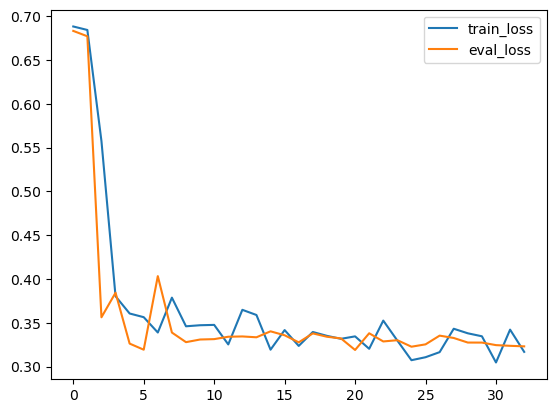

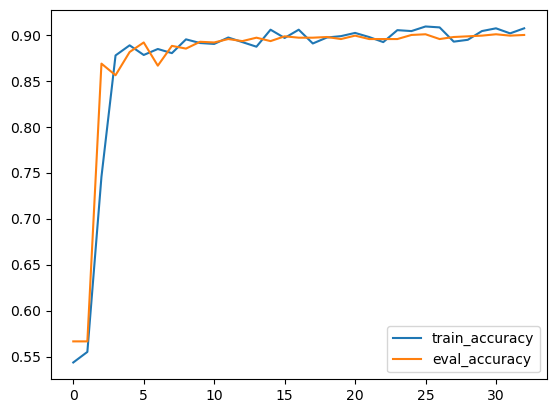

In [11]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    if 'train_accuracy' in log:
        train_accuracy.append(log["train_accuracy"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [12]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./bitfit_results/checkpoint-{best_checkpoint}")

# Test the best model
trainer = Trainer(
    model=best_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()


13000


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 218/218 [00:15<00:00, 13.63it/s]


{'eval_loss': 0.3099214434623718,
 'eval_accuracy': 0.9059633027522935,
 'eval_runtime': 16.0812,
 'eval_samples_per_second': 54.225,
 'eval_steps_per_second': 13.556}